# Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils as u
import re
import geopandas as gpd
import ast

pd.options.display.max_columns = None

# Limpieza de Datos

In [2]:
restautantes = pd.read_csv('../data/raw/lugares_madrid.csv')
detalle_restaurantes = pd.read_csv('../data/raw/detalle_sitios.csv')
restautantes = pd.merge(restautantes, detalle_restaurantes, left_on='id', right_on='place_id')

In [3]:
restautantes.drop(['id', 'summary'], inplace=True, axis=1)
restautantes = restautantes[restautantes['rating'].notnull()]

In [4]:
restautantes['dine_in'] = restautantes['dine_in'].astype(bool).fillna(True)
restautantes['price_level'] = restautantes['price_level'].fillna(1)
restautantes['reservable'] = restautantes['reservable'].astype(bool).fillna(False)
restautantes['serves_beer'] = restautantes['serves_beer'].astype(bool).fillna(True)
restautantes['serves_breakfast'] = restautantes['serves_breakfast'].astype(bool).fillna(False)
restautantes['serves_brunch'] = restautantes['serves_brunch'].astype(bool).fillna(False)
restautantes['serves_dinner'] = restautantes['serves_dinner'].astype(bool).fillna(True)
restautantes['serves_lunch'] = restautantes['serves_lunch'].astype(bool).fillna(True)
restautantes['serves_vegetarian_food'] = restautantes['serves_vegetarian_food'].astype(bool).fillna(False)
restautantes['serves_wine'] = restautantes['serves_wine'].astype(bool).fillna(True)
restautantes['takeout'] = restautantes['takeout'].astype(bool).fillna(False)
restautantes['delivery'] = restautantes['delivery'].astype(bool).fillna(False)

In [5]:
restautantes_geo = gpd.GeoDataFrame(restautantes, geometry=gpd.points_from_xy(restautantes['lon'], restautantes['lat']), crs='EPSG:4326')

In [6]:
barrios = gpd.read_file('../data/raw/Barrios.json')
barrios = gpd.GeoDataFrame(barrios, geometry='geometry', crs='EPSG:4326')

In [7]:
restautantes_geo = gpd.sjoin(restautantes_geo, barrios, how='left', predicate='intersects')
restautantes_geo.drop(['index_right', 'id', 'Shape_Leng', 'Shape_Area','FCH_ALTA', 
                       'FCH_BAJA', 'OBSERVACIO', 'APROBACION', 'COD_DIS_TX', 'COD_DISB',
                       'BARRIO_MAY','BARRIO_MT', 'COD_DISBAR', 'NUM_BAR'], axis=1 , inplace=True)

In [8]:
restautantes_geo = restautantes_geo.to_crs(epsg=25830) #cambiar lat y log a seudonimo en distancia en metros para España

In [9]:
restautantes_geo_buffer = restautantes_geo.copy()
restautantes_geo_buffer['buffer_2000'] = restautantes_geo_buffer.geometry.buffer(2000)
restautantes_geo_buffer = restautantes_geo_buffer.set_geometry('buffer_2000')

In [10]:
restautantes_geo.drop(['nombre','lat', 'lon', 'dine_in', 'address', 'reservable', 'serves_beer', 'serves_breakfast',
       'serves_brunch', 'serves_dinner', 'serves_lunch',
       'serves_vegetarian_food', 'serves_wine', 'takeout', 'delivery',
       'CODDIS', 'NOMDIS','COD_BAR', 'NOMBRE'], axis=1, inplace=True)

In [11]:
result_restaurantes = gpd.sjoin(restautantes_geo, restautantes_geo_buffer, how='right', predicate='intersects')
result_restaurantes.drop('index_left', axis=1, inplace=True)

In [12]:
result = result_restaurantes.groupby(['place_id_right','CODDIS', 'NOMDIS','COD_BAR', 'NOMBRE'])[['price_level_left', 'rating_left', 'user_ratings_total_left']].mean().reset_index()
result.rename({'place_id_right':'place_id',
               'price_level_left':'price_level_mean',
               'rating_left':'rating_mean',
               'user_ratings_total_left':'user_ratings_mean'}, axis=1, inplace=True)

In [13]:
restautantes = pd.merge(restautantes, result, how='left', left_on='place_id', right_on='place_id')

In [14]:
restautantes['COD_BAR'] = restautantes['COD_BAR'].astype('int')
restautantes['COD_BAR'] = restautantes['COD_BAR'].astype('str')

In [15]:
kpi = pd.read_csv('../data/raw/kpi_barrios_madrid.csv')

In [16]:
kpi['cod_barrio'] = kpi['cod_barrio'].astype('int')
kpi['cod_barrio'] = kpi['cod_barrio'].astype('str')

In [17]:
kpi['valor_indicador'] = kpi['valor_indicador'].str.replace(',', '.').astype('float')
kpi['valor_indicador'] = kpi['valor_indicador'].fillna(0)

In [18]:
kpi = kpi.pivot(index='cod_barrio', columns='indicador_completo', values='valor_indicador').reset_index()
kpi.fillna(0, inplace=True)

In [19]:
restautantes = pd.merge(restautantes, kpi, how='left', left_on='COD_BAR', right_on='cod_barrio')

In [20]:
street_map = pd.read_csv('../data/raw/sitios_streetmap.csv')

In [21]:
street_map.drop('wheelchair', axis=1, inplace=True)
street_map = street_map[(street_map['cocina'].notnull())&(street_map['nombre'].notnull())]

In [22]:
street_map['cocina'] = [re.sub(r'[^a-zA-Z0-9\s]', ' ', i.lower()) for i in street_map['cocina']]

In [23]:
with open('../data/raw/tipo_cocina.txt', 'r', encoding="utf-8") as file:
    data = file.read()

tipos_cocina = ast.literal_eval(data)

In [24]:
street_map['cocina_map'] = street_map['cocina'].map(tipos_cocina)
street_map = street_map[street_map['cocina_map'].notnull()]

In [25]:
street_map['nombre'] = street_map['nombre'].apply(u.eliminar_acentos)
street_map['nombre'] = [re.sub(r'[^a-zA-Z0-9\s]', ' ', i.lower()) for i in street_map['nombre']]

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X = street_map['nombre']
y = street_map['cocina_map']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)

pipe = Pipeline(steps=[("scaler", CountVectorizer()),
    ('classifier', MultinomialNB())
])

logistic_params = {
    'scaler':[CountVectorizer()],
    'classifier': [LogisticRegression(max_iter=10000, solver='liblinear'), LogisticRegression(max_iter=10, solver='liblinear')],
    'classifier__penalty': ['l1', 'l2']
}

random_forest_params = {
    'scaler': [CountVectorizer()],
    'classifier': [RandomForestClassifier()],
    'classifier__max_depth': np.arange(2, 9),
    'classifier__n_estimators': [100, 200, 500],
}

naive_param = {
    'scaler': [CountVectorizer()],
    'classifier': [MultinomialNB()],
    'classifier__alpha': [0.28, 0.30, 0.31],
}

cnaive_param = {
    'scaler': [CountVectorizer()],
    'classifier': [ComplementNB()],
    'classifier__alpha': [0.1, 0.25, 0.50, 0.75, 0.80, 1],
}

search_space = [
    logistic_params,
    random_forest_params,
    naive_param,
    cnaive_param
]

clf = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = 5,
                  n_jobs=-1)

clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', CountVectorizer()),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(max_iter=10000,
                                                            solver='liblinear'),
                                         LogisticRegression(max_iter=10,
                                                            solver='liblinear')],
                          'classifier__penalty': ['l1', 'l2'],
                          'scaler': [CountVectorizer()]},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__max_depth': array([2, 3, 4, 5, 6, 7, 8]),
                          'classifier__n_estimators': [100, 200, 500],
                          'scaler': [CountVectorizer()]},
                         {'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.28, 0.3, 0.31],
                          'scaler': [CountVectorizer()]},
                         {'classifier': [ComplementNB()],
                          'classifier__alpha': [0.1, 0.25, 0.5, 0.75, 0.8, 1],
                          'scaler': [CountVectorizer()]}])

In [27]:
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

Pipeline(steps=[('scaler', CountVectorizer()),
                ('classifier', MultinomialNB(alpha=0.3))])
0.7347621613278077
{'classifier': MultinomialNB(), 'classifier__alpha': 0.3, 'scaler': CountVectorizer()}


In [28]:
cocina_mod = clf.best_estimator_
y_pred = cocina_mod.predict(X_test)

cocina_mod.score(y_test, y_pred)

0.769690927218345

In [29]:
restautantes['nombre'] = restautantes['nombre'].apply(u.eliminar_acentos)
restautantes['nombre'] = [re.sub(r'[^a-zA-Z0-9\s]', ' ', i.lower()) for i in restautantes['nombre']]

In [30]:
restautantes['tipo_cocina']  = cocina_mod.predict(restautantes['nombre'])

In [31]:
from sklearn.preprocessing import OneHotEncoder

enc_cocina = OneHotEncoder(handle_unknown='ignore')
tip_coci= enc_cocina.fit_transform(restautantes[['tipo_cocina']]).toarray()
tip_cocina_dummy = pd.DataFrame(tip_coci, columns=[cat for cat in enc_cocina.categories_[0]])

enc_distrito = OneHotEncoder(handle_unknown='ignore')
tip_distrito= enc_distrito.fit_transform(restautantes[['NOMDIS']]).toarray()
tip_distrito_dummy = pd.DataFrame(tip_distrito, columns=[cat for cat in enc_distrito.categories_[0]])

enc_barrio = OneHotEncoder(handle_unknown='ignore')
tip_barrio= enc_barrio.fit_transform(restautantes[['NOMBRE']]).toarray()
tip_barrio_dummy = pd.DataFrame(tip_barrio, columns=[cat for cat in enc_barrio.categories_[0]])

restautantes = pd.concat([restautantes, tip_cocina_dummy, tip_distrito_dummy, tip_barrio_dummy], axis=1)

In [32]:
restautantes.shape

(2544, 315)

In [33]:
restautantes.drop(['cod_barrio', 'NOMDIS', 'NOMBRE', 
                   'Población en etapa educativa (Población de 0 a 16 años -16 no incluidos)',
                   'Primera y segunda nacionalidad extranjera en el Distrito: CHINA',
                   'Primera y segunda nacionalidad extranjera en el Distrito: CHINA (Población total Distrito)',
                   'Primera y segunda nacionalidad extranjera en el Distrito: COLOMBIA',
                   'Primera y segunda nacionalidad extranjera en el Distrito: FILIPINAS (Población total Distrito)',
                   'Primera y segunda nacionalidad extranjera en el Distrito: FRANCIA',
                   'Primera y segunda nacionalidad extranjera en el Distrito: HONDURAS',
                   'Primera y segunda nacionalidad extranjera en el Distrito: ITALIA',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: ITALIA (Población total Distrito)',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: ITALIA (Total en Distrito)',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: MARRUECOS (Población total Distrito)',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: PARAGUAY',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: PARAGUAY (Población total Distrito)',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: PERÚ',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: PERÚ (Población total Distrito)',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: RUMANÍA',
                   'Primera y segunda nacionalidad extranjera en el Distrito: VENEZUELA',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: VENEZUELA (Población total Distrito)',
                   'Tasa absoluta de paro registrado hombres',
                   'Tasa absoluta de paro registrado mujeres',
                   'Primera y segunda nacionalidad extranjera en el Distrito: FILIPINAS'
                   ], axis=1, inplace=True)

In [34]:
restautantes.shape

(2544, 291)

In [35]:
restautantes.rename(columns={
                    'nombre':'nombre_restaurante',
                    'address':'direccion',
                    'CODDIS':'cod_distrito',
                    'COD_BAR':'cod_barrio',
                    'Apartamentos Municipales para Mayores':'apt_municip_mayores',
                    'Asociaciones (Sección 1ª)':'asocia_sec_1',
                    'Asociaciones culturales y casas regionales':'asocia_cult_casas_reg',
                    'Asociaciones de mujeres':'asocia_mujeres',
                    'Asociaciones vecinales':'asocia_vecinales',
                    'Año medio de contrucción de inmuebles de uso residencial':'anio_medio_constr_vivendas',
                    'Bibliotecas Comunidad Madrid':'bibliotecas_comunidad',
                    'Bibliotecas Municipales':'bibliotecas_municipal',
                    'Bibliotecas públicas Comunidad Madrid':'bibliotecas_comunidad_public',
                    'Bibliotecas públicas Municipales':'bibliotecas_municipal_public',
                    'Campos de fútbol 11':'campus_futb_11',
                    'Centro de Día de Atención a Niños y Niñas (de 3 a 12 años)':'centro_ninos_3_12_anios',
                    'Centros Municipales de Mayores':'centro_municipal_mayor',
                    'Centros Municipales de Salud Comunitaria (CMSC)':'cmsc',
                    'Centros de Adolescentes y Jóvenes (ASPA)':'aspa',
                    'Centros de Apoyo a las Familias (CAF)':'caf',
                    'Centros de Atención a la Infancia (CAI)':'cai',
                    'Centros de Atención a las Adicciones (CAD y CCAD)':'cad_y_ccad',
                    'Centros de Día de Alzheimer y Físicos':'centro_dia_alzheimer_fisicos',
                    'Centros de Servicios Sociales':'centro_serv_social',
                    'Centros deportivos Municipales':'centro_deport_municipal',
                    'Centros para personas sin hogar':'centro_pers_sin_hogar',
                    'Centros y Espacios Culturales':'centro_espacio_cultural',
                    'Colegios Públicos Infantil y Primaria':'colegio_publ_infatil_primaria',
                    'Duración media del crédito (meses) en transacción de vivienda':'dur_media_credito_viviendas',
                    'Duración media del crédito (meses) en transacción de vivienda (2019)': 'dur_media_credito_viviendas_2019',
                    'Edad media de la población':'edad_media_poblacion',
                    'Elecciones  municipales, votos en blanco':'votos_blancos_elec_municipal',
                    'Elecciones municipales, abstenciones':'abstenciones_elec_municipal',
                    'Elecciones municipales, censo electoral':'censo_elec_municipal',
                    'Elecciones municipales, votos a Ciudadanos-Partido de la Ciudadanía':'votos_ciudadanos_elec_municipal',
                    'Elecciones municipales, votos a Más Madrid':'votos_masmadrid_elec_municipal',
                    'Elecciones municipales, votos a Más Madrid-Verdes Equo':'votos_masverdeequo_elec_municipal',
                    'Elecciones municipales, votos a Podemos-Izquierda Unida-Alianza Verde':'votos_podemos_elec_municipal',
                    'Elecciones municipales, votos a VOX':'votos_vox_elec_municipal',
                    'Elecciones municipales, votos a candidaturas':'votos_candidaturas_elec_municipal',
                    'Elecciones municipales, votos al Partido Popular':'votos_pp_elec_municipal',
                    'Elecciones municipales, votos al Partido Socialista Obrero Español':'votos_psoe_elec_municipal',
                    'Escuelas Infantiles Municipales':'escuelas_inf_municipal',
                    'Espacios de Igualdad':'espacio_igualdad',
                    'Espacios de Ocio para Adolescentes (El Enredadero)':'espacio_adolecentes_ocio',
                    'Esperanza de vida al nacer Hombres  (mortalidad del periodo 2013-2016)':'esperanza_vida_hombres',
                    'Esperanza de vida al nacer Mujeres (mortalidad del periodo 2013-2016)':'esperanza_vida_mujeres',
                    'Etapas educativas. Total niñas':'etapa_educativa_ninas',
                    'Etapas educativas. Total niños':'etapa_educativa_ninos',
                    'Fundaciones (Sección 2ª)':'fundacion_sec_2',
                    'Hogares con un hombre solo mayor de 65 años':'hogar_hombre_mas_65',
                    'Hogares con una mujer sola mayor de 65 años':'hogar_mujer_mas_65',
                    'Hogares monoparentales: un hombre adulto con uno o más menores':'hogar_monoparental_hombre',
                    'Hogares monoparentales: una mujer adulta con uno o más menores':'hogar_monoparental_mujer',
                    'Instalaciones deportivas básicas':'instalaciones_deportivas_basc',
                    'Institutos Públicos de Educación Secundaria':'inst_publico_secundaria',
                    'Mercados Municipales':'mercado_municipales',
                    'Número Habitantes':'num_habitantes',
                    'Número de inmuebles de uso residencial':'num_inmuebles_residencial',
                    'Número de locales dados de alta abiertos':'num_locales_alta_abiertos',
                    'Número de locales dados de alta cerrados':'num_locales_alta_cerrados',
                    'Número de locales dados de alta en obra':'num_locales_alta_obra',
                    'Número de locales dados de alta en uso como vivienda':'num_locales_alta_vivienda',
                    'Número de locales dados de alta totales':'num_locales_alta_tot',
                    'Paro registrado (número de personas registradas en SEPE en febrero)':'parados',
                    'Paro registrado (número de personas registradas en SEPE en febrero) hombres':'parados_hombre',
                    'Paro registrado (número de personas registradas en SEPE en febrero) mujeres':'parados_mujer',
                    'Pensión media mensual  Mujeres': 'pension_media_mensual_mujeres',
                    'Pensión media mensual Hombres':'pension_media_mensual_hombres',
                    'Personas con nacionalidad española':'personas_espanolas',
                    'Personas con nacionalidad española Hombres':'personas_espanolas_hombre',
                    'Personas con nacionalidad española Mujeres':'personas_espanolas_mujer',
                    'Personas con nacionalidad extranjera':'personas_extranjera',
                    'Personas con nacionalidad extranjera Hombres':'personas_extranjera_hombre',
                    'Personas con nacionalidad extranjera Mujeres':'personas_extranjera_mujer',
                    'Piscinas cubiertas':'piscina_cubierta',
                    'Piscinas de verano':'piscina_verano',
                    'Pista de atletismo':'pista_atletismo',
                    'Población Hombres':'poblacion_hombre',
                    'Población Mujeres':'poblacion_mujer',
                    'Población de 0 a 14 años':'poblacion_0_14',
                    'Población de 15 a 29 años':'poblacion_15_29',
                    'Población de 30 a 44  años':'poblacion_30_44',
                    'Población de 45 a 64 años':'poblacion_45_64',
                    'Población de 65 a 79 años':'poblacion_65_79',
                    'Población de 65 años y más':'poblacion_65_mas',
                    'Población de 80 años y más':'poblacion_80_mas',
                    'Población densidad (hab./Ha.)':'poblacion_densidad',
                    'Población en etapa educativa de 0 a 2 años':'poblacion_etapa_educativa_0_2',
                    'Población en etapa educativa de 12 a 15 años':'poblacion_etapa_educativa_12_15',
                    'Población en etapa educativa de 3 a 5 años':'poblacion_etapa_educativa_3_5',
                    'Población en etapa educativa de 6 a 11 años':'poblacion_etapa_educativa_6_11',
                    'Población en etapas educativas':'poblacion_etapa_educativa',
                    'Población infantil femenina en etapa educativa de 0 a 2 años':'poblacion_etapa_educativa_0_2_mujer',
                    'Población infantil femenina en etapa educativa de 12 a 15 años':'poblacion_etapa_educativa_12_15_mujer',
                    'Población infantil femenina en etapa educativa de 3 a 5 años':'poblacion_etapa_educativa_3_5_mujer',
                    'Población infantil femenina en etapa educativa de 6 a 11 años':'poblacion_etapa_educativa_6_11_mujer',
                    'Población infantil masculina en etapa educativa de 0 a 2 años':'poblacion_etapa_educativa_0_2_hombre',
                    'Población infantil masculina en etapa educativa de 12 a 15 años':'poblacion_etapa_educativa_12_15_hombre',
                    'Población infantil masculina en etapa educativa de 3 a 5 años':'poblacion_etapa_educativa_3_5_hombre',
                    'Población infantil masculina en etapa educativa de 6 a 11 años':'poblacion_etapa_educativa_6_11_hombre',
                    'Población mayor/igual  de 25 años  con estudios superiores, licenciatura, arquitectura, ingeniería sup., estudios sup. no universitarios, doctorado,  postgraduado':'pobl_25_mas_est_superiores',
                    'Población mayor/igual  de 25 años  que no sabe leer ni escribir o sin estudios':'pobl_25_mas_no_letrados',
                    'Población mayor/igual  de 25 años con Bachiller Elemental, Graduado Escolar, ESO, Formación profesional 1º grado':'pobl_25_mas_bachiller_eso_fp1',
                    'Población mayor/igual  de 25 años con Formación profesional 2º grado, Bachiller Superior o BUP':'pobl_25_mas_bachillersup_fp2',
                    'Población mayor/igual  de 25 años con Nivel de estudios desconocido y/o no consta':'pobl_25_mas_estudio_desconocido',
                    'Población mayor/igual  de 25 años con enseñanza primaria incompleta':'pobl_25_mas_primaria_incompleta',
                    'Población mayor/igual  de 25 años con titulación media, diplomatura, arquitectura o ingeniería técnica':'pobl_25_titu_media',
                    'Porcentaje de envejecimiento (Población mayor de 65 años/Población total)':'pct_evejecimiento',
                    'Porcentaje de sobre-envejecimiento (Población mayor de 80 años/ Población mayor de 65 años)':'pct_sobrevejecimiento',
                    'Posición en el ranking de distritos y/o barrios de vulnerabilidad territorial':'posicion_ranking_vulnerabilidad',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nBANGLADESH (Población total Distrito)':'poblacion_bangladesh',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nBOLIVIA (Población total Distrito)':'poblacion_bolivia',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nCHINA (Población total Distrito)':'poblacion_china',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nECUADOR (Población total Distrito)':'poblacion_ecuador',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nFILIPINAS (Población total Distrito)':'poblacion_filipinas',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nFRANCIA (Población total Distrito)':'poblacion_francia',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nITALIA (Población total Distrito)':'poblacion_italia',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nMARRUECOS (Población total Distrito)':'poblacion_marruecos',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nPARAGUAY (Población total Distrito)':'poblacion_paraguay',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nPERÚ (Población total Distrito)':'poblacion_peru',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nRUMANÍA (Población total Distrito)':'poblacion_rumania',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nVENEZUELA (Población total Distrito)':'poblacion_venezuela',
                    'Primera y segunda nacionalidad extranjera en el Distrito: COLOMBIA (Población total Distrito)':'poblacion_colombia',
                    'Primera y segunda nacionalidad extranjera en el Distrito: FRANCIA (Población total Distrito)':'poblacion_francia',
                    'Primera y segunda nacionalidad extranjera en el Distrito: HONDURAS (Población total Distrito) 2':'poblacion_honduras',
                    'Proporción de personas migrantes  (Personas extranjeras menos UE y resto países de OCDE / Población total)':'pct_migrantes(personas_extranjeras_menos_UE/poblacion_total)',
                    'Proporción de personas migrantes (Población extranjera menos UE y resto países de OCDE / Población total)':'pct_migrantes(poblacion_extranjeras_menos_UE/poblacion_total)',
                    'Renta disponible media por persona':'renta_media_persona',
                    'Renta neta media anual de los hogares (Urban Audit)':'renta_neta_anual_hogar',
                    'Residencias para personas Mayores':'residencia_mayores',
                    'Superficie (Ha.)':'superficie',
                    'Superficie media construida (m2) inmuebles de uso residencial':'superficie_media_residencias',
                    'Superficie media de la vivienda (m2) en transacción':'superficie_media_vivienda_transac',
                    'Tamaño medio del hogar':'tamano_hogar_medio',
                    'Tasa absoluta de paro registrado (febrero)':'pct_abs_paro',
                    'Tasa absoluta de paro registrado Hombres':'pct_abs_paro_hombre',
                    'Tasa absoluta de paro registrado Mujeres':'pct_abs_paro_mujer',
                    'Tasa bruta de natalidad (‰)':'pct_bruta_natalidad',
                    'Tasa de crecimiento demográfico (porcentaje)':'pct_crecimiento_demografico',
                    'Tasa de desempleo en hombres de 16 a 24 años':'pct_desempleo_hombre_16-24',
                    'Tasa de desempleo en hombres de 25 a 44 años':'pct_desempleo_hombre_25-44',
                    'Tasa de desempleo en hombres de 45 a 64 años':'pct_desempleo_hombre_45-64',
                    'Tasa de desempleo en mujeres de 16 a 24 años':'pct_desempleo_mujer_16-24',
                    'Tasa de desempleo en mujeres de 25 a 44 años':'pct_desempleo_mujer_25-44',
                    'Tasa de desempleo en mujeres de 45 a 64 años':'pct_desempleo_mujer_45-64',
                    'Total hogares':'tot_hogares',
                    'Valor catastral medio por inmueble de uso residencial':'valor_catast_inmueble_residen',
                    'Índice de Vulnerabilidad Bienestar Social e Igualdad':'indice_vulnerabilidad_bienestar_social_igual',
                    'Índice de Vulnerabilidad Economía y Empleo':'indice_vulnerabilidad_eco_empleo',
                    'Índice de Vulnerabilidad Educación y Cultura':'indice_vulnerabilidad_edu_cultura',
                    'Índice de Vulnerabilidad Medio Ambiente Urbano y Movilidad':'indice_vulnerabilidad_ambiente_urbano y movi',
                    'Índice de Vulnerabilidad Salud':'indice_vulnerabilidad_salud',
                    'Índice de Vulnerabilidad Territorial':'indice_vulnerabilidad_territorial',
                    'Índice de dependencia (Población de 0-15 + población 65 años y más / Pob. 16-64)':'indice_dependiencia(bebes y aldutos mayores/pob 16-64)'
                    }, inplace=True)

In [36]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
tipo_cocina_encoder = encoder.fit_transform(restautantes['tipo_cocina'])
restautantes['tipo_cocina_encoder'] = tipo_cocina_encoder

In [37]:
restautantes['y'] = restautantes['rating']*(np.log(restautantes['user_ratings_total']+1))

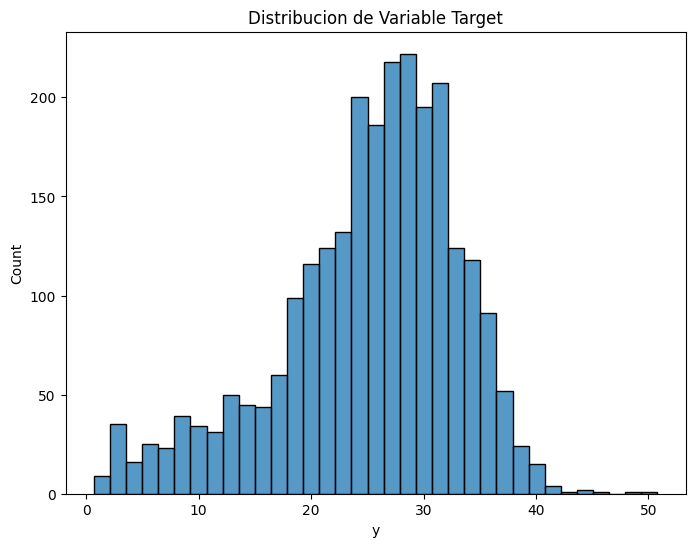

In [38]:
plt.figure(figsize=(8,6))
sns.histplot(restautantes['y'])
plt.title(label='Distribucion de Variable Target')
plt.show()

In [41]:
restautantes.corr(numeric_only=True)

,lat,lon,dine_in,price_level,rating,reservable,serves_beer,serves_breakfast,serves_brunch,serves_dinner,serves_lunch,serves_vegetarian_food,serves_wine,takeout,user_ratings_total,delivery,price_level_mean,rating_mean,user_ratings_mean,apt_municip_mayores,asocia_sec_1,asocia_cult_casas_reg,asocia_mujeres,asocia_vecinales,anio_medio_constr_vivendas,bibliotecas_comunidad,bibliotecas_municipal,bibliotecas_comunidad_public,bibliotecas_municipal_public,campus_futb_11,centro_ninos_3_12_anios,centro_municipal_mayor,cmsc,aspa,caf,cai,cad_y_ccad,centro_dia_alzheimer_fisicos,centro_serv_social,centro_deport_municipal,centro_pers_sin_hogar,centro_espacio_cultural,colegio_publ_infatil_primaria,dur_media_credito_viviendas,dur_media_credito_viviendas_2019,edad_media_poblacion,votos_blancos_elec_municipal,abstenciones_elec_municipal,censo_elec_municipal,votos_ciudadanos_elec_municipal,votos_masmadrid_elec_municipal,votos_masverdeequo_elec_municipal,votos_podemos_elec_municipal,votos_vox_elec_municipal,votos_candidaturas_elec_municipal,votos_pp_elec_municipal,votos_psoe_elec_municipal,escuelas_inf_municipal,espacio_igualdad,espacio_adolecentes_ocio,esperanza_vida_hombres,esperanza_vida_mujeres,etapa_educativa_ninas,etapa_educativa_ninos,fundacion_sec_2,hogar_hombre_mas_65,hogar_mujer_mas_65,hogar_monoparental_hombre,hogar_monoparental_mujer,instalaciones_deportivas_basc,inst_publico_secundaria,mercado_municipales,num_habitantes,num_inmuebles_residencial,num_locales_alta_abiertos,num_locales_alta_cerrados,num_locales_alta_obra,num_locales_alta_vivienda,num_locales_alta_tot,parados,parados_hombre,parados_mujer,pension_media_mensual_mujeres,pension_media_mensual_hombres,personas_espanolas,personas_espanolas_hombre,personas_espanolas_mujer,personas_extranjera,personas_extranjera_hombre,personas_extranjera_mujer,piscina_cubierta,piscina_verano,pista_atletismo,poblacion_hombre,poblacion_mujer,poblacion_0_14,poblacion_15_29,poblacion_30_44,poblacion_45_64,poblacion_65_79,poblacion_65_mas,poblacion_80_mas,poblacion_densidad,poblacion_etapa_educativa_0_2,poblacion_etapa_educativa_12_15,poblacion_etapa_educativa_3_5,poblacion_etapa_educativa_6_11,poblacion_etapa_educativa,poblacion_etapa_educativa_0_2_mujer,poblacion_etapa_educativa_12_15_mujer,poblacion_etapa_educativa_3_5_mujer,poblacion_etapa_educativa_6_11_mujer,poblacion_etapa_educativa_0_2_hombre,poblacion_etapa_educativa_12_15_hombre,poblacion_etapa_educativa_3_5_hombre,poblacion_etapa_educativa_6_11_hombre,pobl_25_mas_est_superiores,pobl_25_mas_no_letrados,pobl_25_mas_bachiller_eso_fp1,pobl_25_mas_bachillersup_fp2,pobl_25_mas_estudio_desconocido,pobl_25_mas_primaria_incompleta,pobl_25_titu_media,pct_evejecimiento,pct_sobrevejecimiento,posicion_ranking_vulnerabilidad,poblacion_bangladesh,poblacion_bolivia,poblacion_china,poblacion_ecuador,poblacion_filipinas,poblacion_francia,poblacion_italia,poblacion_marruecos,poblacion_paraguay,poblacion_peru,poblacion_rumania,poblacion_venezuela,poblacion_colombia,poblacion_francia,poblacion_honduras,pct_migrantes(personas_extranjeras_menos_UE/poblacion_total),pct_migrantes(poblacion_extranjeras_menos_UE/poblacion_total),renta_media_persona,renta_neta_anual_hogar,residencia_mayores,superficie,superficie_media_residencias,superficie_media_vivienda_transac,tamano_hogar_medio,pct_abs_paro,pct_abs_paro_hombre,pct_abs_paro_mujer,pct_bruta_natalidad,pct_crecimiento_demografico,pct_desempleo_hombre_16-24,pct_desempleo_hombre_25-44,pct_desempleo_hombre_45-64,pct_desempleo_mujer_16-24,pct_desempleo_mujer_25-44,pct_desempleo_mujer_45-64,tot_hogares,valor_catast_inmueble_residen,indice_vulnerabilidad_bienestar_social_igual,indice_vulnerabilidad_eco_empleo,indice_vulnerabilidad_edu_cultura,indice_vulnerabilidad_ambiente_urbano y movi,indice_vulnerabilidad_salud,indice_vulnerabilidad_territorial,indice_dependiencia(bebes y aldutos mayores/pob 16-64),Americana / Burgers,Asiática,China,Española,Fusión,Italiana,Japonesa,Latinoamericana,Mexicana,Otros,Arganzuela,Carabanchel,C

In [42]:
restautantes.describe()

,lat,lon,price_level,rating,user_ratings_total,price_level_mean,rating_mean,user_ratings_mean,apt_municip_mayores,asocia_sec_1,asocia_cult_casas_reg,asocia_mujeres,asocia_vecinales,anio_medio_constr_vivendas,bibliotecas_comunidad,bibliotecas_municipal,bibliotecas_comunidad_public,bibliotecas_municipal_public,campus_futb_11,centro_ninos_3_12_anios,centro_municipal_mayor,cmsc,aspa,caf,cai,cad_y_ccad,centro_dia_alzheimer_fisicos,centro_serv_social,centro_deport_municipal,centro_pers_sin_hogar,centro_espacio_cultural,colegio_publ_infatil_primaria,dur_media_credito_viviendas,dur_media_credito_viviendas_2019,edad_media_poblacion,votos_blancos_elec_municipal,abstenciones_elec_municipal,censo_elec_municipal,votos_ciudadanos_elec_municipal,votos_masmadrid_elec_municipal,votos_masverdeequo_elec_municipal,votos_podemos_elec_municipal,votos_vox_elec_municipal,votos_candidaturas_elec_municipal,votos_pp_elec_municipal,votos_psoe_elec_municipal,escuelas_inf_municipal,espacio_igualdad,espacio_adolecentes_ocio,esperanza_vida_hombres,esperanza_vida_mujeres,etapa_educativa_ninas,etapa_educativa_ninos,fundacion_sec_2,hogar_hombre_mas_65,hogar_mujer_mas_65,hogar_monoparental_hombre,hogar_monoparental_mujer,instalaciones_deportivas_basc,inst_publico_secundaria,mercado_municipales,num_habitantes,num_inmuebles_residencial,num_locales_alta_abiertos,num_locales_alta_cerrados,num_locales_alta_obra,num_locales_alta_vivienda,num_locales_alta_tot,parados,parados_hombre,parados_mujer,pension_media_mensual_mujeres,pension_media_mensual_hombres,personas_espanolas,personas_espanolas_hombre,personas_espanolas_mujer,personas_extranjera,personas_extranjera_hombre,personas_extranjera_mujer,piscina_cubierta,piscina_verano,pista_atletismo,poblacion_hombre,poblacion_mujer,poblacion_0_14,poblacion_15_29,poblacion_30_44,poblacion_45_64,poblacion_65_79,poblacion_65_mas,poblacion_80_mas,poblacion_densidad,poblacion_etapa_educativa_0_2,poblacion_etapa_educativa_12_15,poblacion_etapa_educativa_3_5,poblacion_etapa_educativa_6_11,poblacion_etapa_educativa,poblacion_etapa_educativa_0_2_mujer,poblacion_etapa_educativa_12_15_mujer,poblacion_etapa_educativa_3_5_mujer,poblacion_etapa_educativa_6_11_mujer,poblacion_etapa_educativa_0_2_hombre,poblacion_etapa_educativa_12_15_hombre,poblacion_etapa_educativa_3_5_hombre,poblacion_etapa_educativa_6_11_hombre,pobl_25_mas_est_superiores,pobl_25_mas_no_letrados,pobl_25_mas_bachiller_eso_fp1,pobl_25_mas_bachillersup_fp2,pobl_25_mas_estudio_desconocido,pobl_25_mas_primaria_incompleta,pobl_25_titu_media,pct_evejecimiento,pct_sobrevejecimiento,posicion_ranking_vulnerabilidad,poblacion_bangladesh,poblacion_bolivia,poblacion_china,poblacion_ecuador,poblacion_filipinas,poblacion_francia,poblacion_italia,poblacion_marruecos,poblacion_paraguay,poblacion_peru,poblacion_rumania,poblacion_venezuela,poblacion_colombia,poblacion_francia,poblacion_honduras,pct_migrantes(personas_extranjeras_menos_UE/poblacion_total),pct_migrantes(poblacion_extranjeras_menos_UE/poblacion_total),renta_media_persona,renta_neta_anual_hogar,residencia_mayores,superficie,superficie_media_residencias,superficie_media_vivienda_transac,tamano_hogar_medio,pct_abs_paro,pct_abs_paro_hombre,pct_abs_paro_mujer,pct_bruta_natalidad,pct_crecimiento_demografico,pct_desempleo_hombre_16-24,pct_desempleo_hombre_25-44,pct_desempleo_hombre_45-64,pct_desempleo_mujer_16-24,pct_desempleo_mujer_25-44,pct_desempleo_mujer_45-64,tot_hogares,valor_catast_inmueble_residen,indice_vulnerabilidad_bienestar_social_igual,indice_vulnerabilidad_eco_empleo,indice_vulnerabilidad_edu_cultura,indice_vulnerabilidad_ambiente_urbano y movi,indice_vulnerabilidad_salud,indice_vulnerabilidad_territorial,indice_dependiencia(bebes y aldutos mayores/pob 16-64),Americana / Burgers,Asiática,China,Española,Fusión,Italiana,Japonesa,Latinoamericana,Mexicana,Otros,Arganzuela,Carabanchel,Centro,Chamartín,Chamberí,Ciudad Lineal,Fuencarral - El Pardo,Hortaleza,Latina,Moncloa - Aravaca,Moratalaz,Puente de Vallecas,Retiro,Salamanca

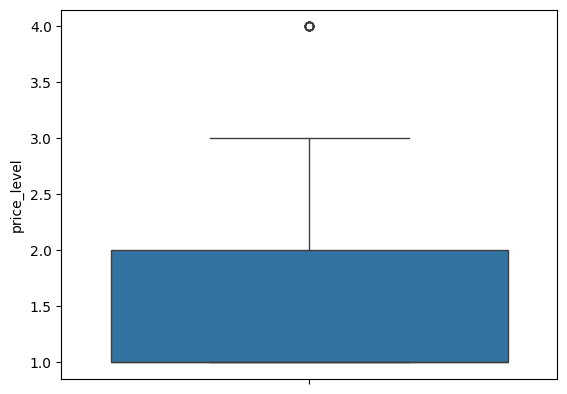

In [46]:
sns.boxplot(restautantes['price_level']);

In [47]:
restautantes.to_csv('../data/processed/restautantes.csv', index=False)